# Préambule
___

In [1]:
import pandas as pd

import data_preambule
import strategies
from tool_kit import*

import sys
import runpy
from joblib import load, Parallel, delayed
from tqdm import tqdm


In [2]:
# parameters
DATA_PATH = '../../data/high_10m.parquet'
NUM_LAGS = 10
NUM_STOCKS = 10
TRAIN_WINDOW = 50
OUTPUT_PATH = '../../data/processed_high_10m_subset.parquet'
SEED = 42
SHRINKAGE_LIST = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]


In [3]:
sys.argv = [
    'data_preambule.py',
    '--data_path', DATA_PATH,
    '--num_lags', str(NUM_LAGS),
    '--num_random_stocks', str(NUM_STOCKS),
    '--output_path', OUTPUT_PATH,
    '--seed', str(SEED)
]

In [4]:
data_preambule.main()

Loading data...
Creating lag features...
Sampling 10 random stocks...
Data ready for modeling.
                                    all_ex  mid_open  sum_delta    return  \
symbol timestamp                                                            
BBIO   2021-12-01 11:10:00  JDQKYZBVPXHUNC    42.645  -0.482734 -0.006407   
       2021-12-01 11:20:00  QXZDBYPCVUKHNJ    42.580   0.488409 -0.001524   
       2021-12-01 11:30:00   QKZUHPDVNYCJB    42.595  -0.348399  0.000352   
       2021-12-01 11:40:00    YDQZUBPKVNHM    42.410  -0.357203 -0.004343   
       2021-12-01 11:50:00     DVQKZHPUNMJ    42.170  -0.923587 -0.005659   

                            return_lag_1  return_lag_2  return_lag_3  \
symbol timestamp                                                       
BBIO   2021-12-01 11:10:00      0.011548      0.005093     -0.005770   
       2021-12-01 11:20:00     -0.006407      0.011548      0.005093   
       2021-12-01 11:30:00     -0.001524     -0.006407      0.011548   
     

In [5]:
# Define the vector of features
features = [f"return_lag_{i}" for i in range(1, 11)]

# Linear Regression
___

In [6]:
# Load dataset
table2 = pd.read_parquet(OUTPUT_PATH)
table2.head(2)

all_ex  mid_open  sum_delta    return  \
symbol timestamp                                                            
BBIO   2021-12-01 11:10:00  JDQKYZBVPXHUNC    42.645  -0.482734 -0.006407   
       2021-12-01 11:20:00  QXZDBYPCVUKHNJ    42.580   0.488409 -0.001524   

                            return_lag_1  return_lag_2  return_lag_3  \
symbol timestamp                                                       
BBIO   2021-12-01 11:10:00      0.011548      0.005093     -0.005770   
       2021-12-01 11:20:00     -0.006407      0.011548      0.005093   

                            return_lag_4  return_lag_5  return_lag_6  \
symbol timestamp                                                       
BBIO   2021-12-01 11:10:00     -0.006319      0.006477     -0.005970   
       2021-12-01 11:20:00     -0.005770     -0.006319      0.006477   

                            return_lag_7  return_lag_8  return_lag_9  \
symbol timestamp                                                       
BBIO   2021-12-01 11:10:00      0.002935      0.045801     -0.001226   
       2021-12-01 11:20:00     -0.005970      0.002935      0.045801   

                            return_lag_10  
symbol timestamp                           
BBIO   2021-12-01 11:10:00       0.000000  
       2021-12-01 11:20:00      -0.001226

In [7]:
# Run in parallel
results_nested = Parallel(n_jobs=-1)(
    delayed(run_regression_for_symbol)(
        symbol, group, features=features, train_window=TRAIN_WINDOW
    )
    for symbol, group in tqdm(table2.groupby("symbol"))
)

# Flatten the list of lists
OLS_regression_results = [item for sublist in results_nested for item in sublist]

# Store the results
pd.DataFrame(OLS_regression_results).to_parquet('../../data/OLS_regression_results.parquet', index=False)

100%|██████████| 10/10 [00:00<00:00, 73.71it/s]


Loading data...
Running Buy & Hold model...
Buy & Hold - SR: -0.0617
Market timing returns - SR: 0.0608
Long short returns - SR: 0.0757
R2 score: -0.4115


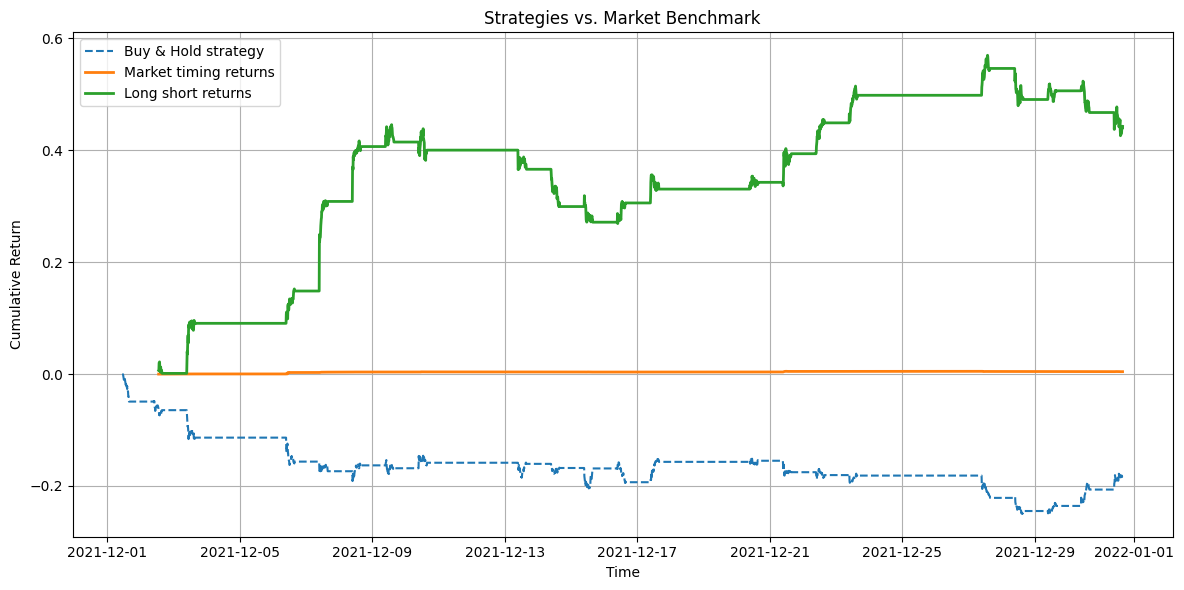

In [8]:
sys.argv = [
    'regressions.py',
    '--data_path', str(OUTPUT_PATH),
    '--model_path', '../../data/',
    '--model', 'ols',
    '--plot', str(False)
]

strategies.main()

# Ridge regression (non-random)
___

In [9]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_ridge_for_symbol)(symbol, group, features=features, train_window= TRAIN_WINDOW, shrinkage_list=SHRINKAGE_LIST)
    for symbol, group in tqdm(table2.groupby("symbol"))
)
# Flatten the nested list of predictions
ridge_regression_results = [item for sublist in results for item in sublist]

# Store the results
pd.DataFrame(ridge_regression_results).to_parquet('../../data/ridge_regression_results.parquet', index=False)

100%|██████████| 10/10 [00:00<00:00, 3568.41it/s]


Loading data...
Running Buy & Hold model...
Buy & Hold - SR: -0.0617
[α=0.0001] Market Timing Sharpe: 0.0622, Long-Short Sharpe: 0.0809, R²: -0.3746
[α=0.001] Market Timing Sharpe: 0.0680, Long-Short Sharpe: 0.1004, R²: -0.2414
[α=0.01] Market Timing Sharpe: 0.0856, Long-Short Sharpe: 0.0850, R²: -0.0590
[α=0.1] Market Timing Sharpe: 0.0973, Long-Short Sharpe: 0.0908, R²: -0.0061
[α=1.0] Market Timing Sharpe: 0.0905, Long-Short Sharpe: 0.0740, R²: -0.0058
[α=10.0] Market Timing Sharpe: 0.0889, Long-Short Sharpe: 0.0743, R²: -0.0062
[α=100.0] Market Timing Sharpe: 0.0887, Long-Short Sharpe: 0.0750, R²: -0.0063


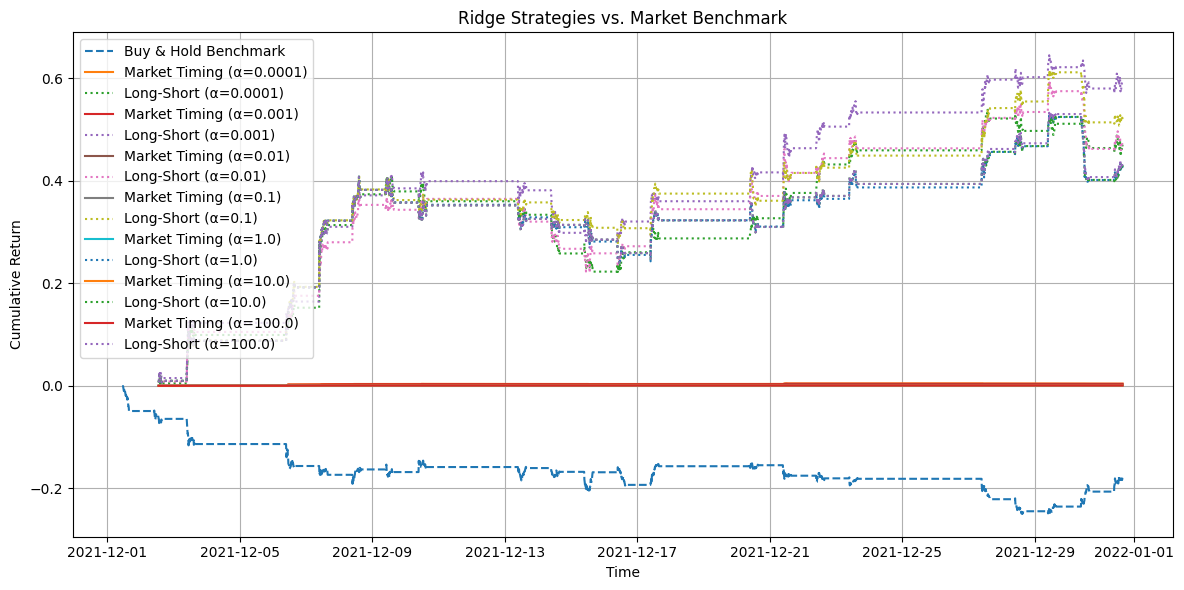

In [10]:
sys.argv = [
    'regressions.py',
    '--data_path', str(OUTPUT_PATH),
    '--model_path', '../../data/',
    '--model', 'ridge',
    '--shrinkage_list', *map(str, SHRINKAGE_LIST),
    '--plot', str(True)
]


strategies.main()

# Ridge with random featuring
___

## Creating random stuff

In [ ]:
functions = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: np.tan(x),
    lambda x: x**2,
    lambda x: np.abs(x),
    lambda x: np.sign(x),
]

In [ ]:
# Creating std_deviation, skew, kurtosis columns for each lag
df_copy = table2.copy()

df_copy['lag_std'] = df_copy[lag_columns].std(axis=1)
df_copy['lag_skew'] = df_copy[lag_columns].skew(axis=1)
df_copy['lag_kurt'] = df_copy[lag_columns].kurt(axis=1)

# Features for regression
features = features + 'lag_std lag_skew lag_kurt'.split()

In [ ]:
F = 5000
# Creating random features coming from non-linear functions
split = int(F/2)

random_features = [f'feature_{feature}' for feature in range(F)]

feature_dict = {}

# Creating random features coming from non-linear functions
for feature in random_features[:split]:
    func = np.random.choice(functions)
    feature_dict[feature] = func(df_copy['return_lag_1'])

# Generate noise based on lagstd of each feature
noise_matrix = np.random.randn(len(df_copy), len(random_features[split:])) * df_copy['lag_std'].values[:, None]
noise_features = dict(zip(random_features[split:], noise_matrix.T))

all_features = {**feature_dict, **noise_features}

df_copy = pd.concat([df_copy, pd.DataFrame(all_features)], axis=1)

features = features + random_features


In [ ]:
table2 = df_copy
del df_copy

## Running the ridge regression

In [ ]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_ridge_for_symbol)(symbol, group, features=features, train_window= train_window, shrinkage_list=shrinkage_list)
    for symbol, group in tqdm.tqdm(table2.groupby("SYMBOL"))
)

# Flatten the nested list of predictions
results = [item for sublist in results for item in sublist]

# Convert to DataFrame
df_predictions = pd.DataFrame(results).set_index(['symbol', 'timestamp'])

### Scores

In [ ]:
r2 = r2_score(df_predictions['y_true'], df_predictions['y_pred'])
mae = mean_absolute_error(df_predictions['y_true'], df_predictions['y_pred'])

print(f"Overall R²: {r2:.4f}")
print(f"Overall MAE: {mae:.6f}")

### Managed returns

In [ ]:
# Market benchmark
df_predictions = df_predictions.reset_index()
df_market_returns = df_predictions.groupby('timestamp')['y_true'].mean()

# Our strategy returns
df_market_timing = df_predictions[['symbol','timestamp','alpha','y_pred','managed_return']]
df_market_timing = pd.pivot_table(df_market_timing, values=['managed_return'], index=['symbol', 'timestamp'],
                       columns=['alpha'], aggfunc="mean")
df_market_timing = df_market_timing.groupby(level=1).mean()

In [ ]:
tmp = pd.concat([df_market_returns,df_market_timing], axis = 1)
tmp = tmp/tmp.std()
sr = sharpe_ratio(tmp)

In [ ]:
market_returns = tmp['y_true']
managed_returns = tmp.iloc[:,1:]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(market_returns.cumsum(), label="Market returns", linestyle="--")

for alpha in shrinkage_list:

    plt.plot(
       managed_returns.cumsum()[('managed_return', alpha)],
       label=f"Managed returns (α={alpha})"
    )

plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Managed Strategy vs. Market Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(sr)